In [1]:
import torch
import pandas as pd
from no_training import (
    sample_images,
    predict_images,
    process_points_results, 
    log_results, 
    get_data, 
    process_shapes_results,
    predict_images_without_deciding
)

%matplotlib inline
import seaborn as sns
blue_yellow = ["#FFD700", "#0000FF"]
# blue_yellow.reverse()
sns.set_palette(blue_yellow)

device = torch.device("cpu")
dtype = torch.float32

num_passes = 4
pairs_num = 100

In [2]:
connections, shuffled_connections, all_neurons, neuron_data, all_coords = get_data()
neurons_in_coords = all_neurons.merge(all_coords, on="root_id", how="right")[
    ["root_id", "cell_type"]
].fillna("Unknown")

# Set all cell_types with less than "20" samples to "others"
n = 20

counts = neurons_in_coords["cell_type"].value_counts()

small_categories = counts[counts < n].index
neurons_in_coords["cell_type"] = neurons_in_coords["cell_type"].apply(
    lambda x: "others" if x in small_categories else x
)

In [3]:
base_dir = "images/zero_to_five/train"
sub_dirs = ["yellow", "blue"]
sampled_images = sample_images(base_dir, sub_dirs, pairs_num)

In [4]:
predictions = predict_images_without_deciding(
    sampled_images, neuron_data, connections, all_coords, num_passes
)
predictions["cell_type"] = neurons_in_coords["cell_type"]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyError: 'weight'

In [ ]:
means = pd.DataFrame(predictions.groupby("cell_type").mean()).T
means["num_points"] = [int(a.split("_")[1]) + int(a.split("_")[2]) for a in means.index]

In [23]:
# take the correlation of each column with "num_points"
correlations = means.corr()["num_points"].sort_values(ascending=False)

In [24]:
correlations

cell_type
num_points    1.000000
others        0.705622
Dm9           0.703715
LC28          0.696685
Unknown       0.695606
                ...   
LB2                NaN
LB3                NaN
ORN_VC3            NaN
ORN_VC5            NaN
TPMN               NaN
Name: num_points, Length: 200, dtype: float64

In [28]:
# predictions = predictions.drop(columns=["cell_type"])
df = predictions.T
df["num_points"] = [int(a.split("_")[1]) + int(a.split("_")[2]) for a in df.index]

In [38]:
means = df.groupby("num_points").mean()
# normalize all columns to 0-1
means = (means - means.min()) / (means.max() - means.min())
# remove columns with missing data
means = means.dropna(axis=1)

In [39]:
means["one_tuning_curve"] = [1, 0.4, 0.3, 0.2, 0.1]

In [47]:
# get only columns where the first row is the biggest
temp = means.T
temp[temp[1] == temp.max(axis=1)]

num_points,1,2,3,4,5
one_tuning_curve,1.0,0.4,0.3,0.2,0.1


In [40]:
correlations = means.corr()["one_tuning_curve"].sort_values(ascending=False)
correlations

MemoryError: Unable to allocate 77.3 GiB for an array with shape (101832, 101832) and data type float64

## Shuffling

In [15]:
predictions = predict_images(
    sampled_images,
    neuron_data,
    shuffled_connections,
    all_coords,
    all_neurons,
    num_passes,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

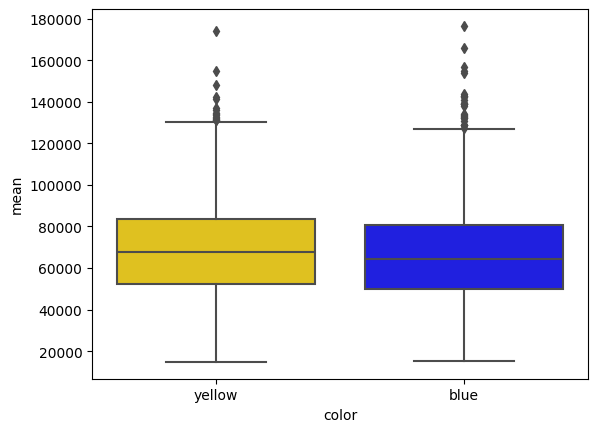

In [21]:
results = process_points_results(predictions)
fig, acc = log_results(results, "points", shuffled=True)
fig

In [24]:
print(f"accuracy = {acc}")

[[0.262 0.238]
 [0.238 0.262]]
accuracy = 0.524


# With shapes

In [9]:
base_dir = "images/black_blue_80_110_jitter/train/two_shapes"
sub_dirs = ["circle", "triangle"]

sampled_images = sample_images(base_dir, sub_dirs, pairs_num)
predictions = predict_images(
    sampled_images, neuron_data, connections, all_coords, all_neurons, num_passes
)

In [32]:
results = process_shapes_results(predictions, sampled_images)
fig, acc = log_results(results, "shapes")

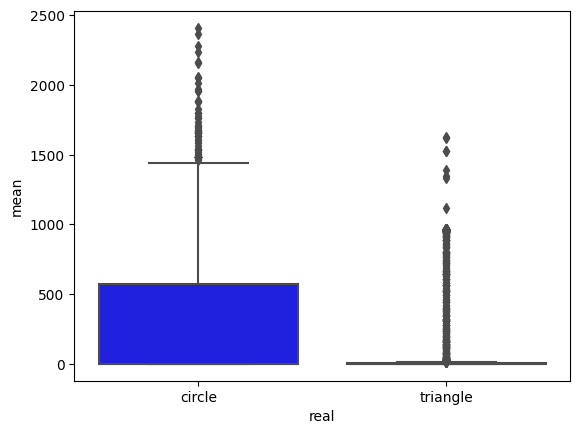

In [63]:
fig

In [54]:
print(f"accuracy = {acc}")

[[0.27725 0.22275]
 [0.35625 0.14375]]
accuracy = 0.579


# Reshuffle de pesos

In [64]:
predictions = predict_images(
    sampled_images, neuron_data, shuffled_connections, all_coords, all_neurons, num_passes
)

In [65]:
results = process_shapes_results(predictions, sampled_images)
fig, acc = log_results(results, "shapes", shuffled=True)
fig

In [67]:
print(f"accuracy = {acc}")

[[0.10775 0.39225]
 [0.39225 0.10775]]
accuracy = 0.7845


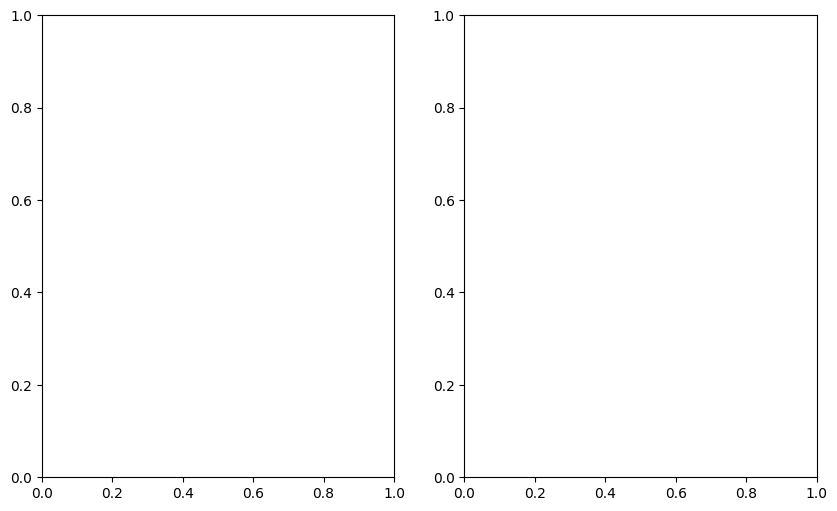

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

In [6]:
"_hola".replace("_", " ")

' hola'